In [1]:
# https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""
Single Image Super-Resolution Using SRGAN
Original paper: https://arxiv.org/pdf/1609.04802.pdf
Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html
    
All images resized to 128x128 to represent HR and 32x32 to represent LR.
"""


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


2022-06-11 01:39:51.224386: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        print("No GPUS detected")


1 Physical GPUs, 1 Logical GPUs


2022-05-31 10:44:52.400233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:44:52.456195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:44:52.456361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 10:44:52.459225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [2]:

#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from tensorflow.keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################


In [4]:
import os 
import cv2

hr_images=[]
lr_images=[]

k=0
n=5000

#for img in os.listdir("/home/wytcor/Desktop/STAGE/YOLOv5_Custom_Training/datasets/DOTAV15/trainsplit/images"):
for img in os.listdir("/users/fogosdarocha/WYCTOR_FOGOS_DA_ROCHA/STAGE/YOLOv5_Custom_Training/datasets/DOTAV15/trainsplit/images"):
    img_array = cv2.imread("/users/fogosdarocha/WYCTOR_FOGOS_DA_ROCHA/STAGE/YOLOv5_Custom_Training/datasets/DOTAV15/trainsplit/images/"+ img)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    hr_img_array = cv2.resize(img_array, (416,416))
    lr_img_array = cv2.resize(img_array,(104,104))
    lr_images.append(lr_img_array/255.)
    hr_images.append(hr_img_array/255.)
    k=k+1
    del hr_img_array
    del lr_img_array
    print(k)
    #if k==n:
    #    break
    #else:
    #    pass

In [5]:

from numpy import save,load

save('data_lr_image_array.npy', lr_images)
save('data_hr_image_array.npy', hr_images)

#print("Saved!")

del hr_images
del lr_images

In [3]:
from numpy import save,load

lr_images = load('data_lr_image_array_128_x_128.npy')
hr_images = load('data_hr_image_array_512_x_512.npy')
print("Loaded!")

Loaded!


In [7]:
#hr_images

In [13]:
#lr_images=np.array(lr_images)
#hr_images=np.array(hr_images)

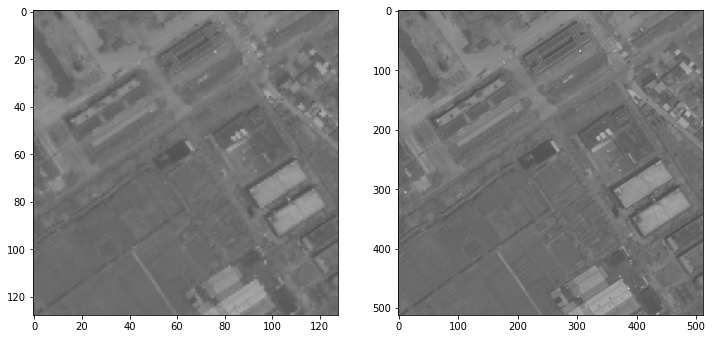

2022-06-11 01:40:57.162569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 01:40:57.219606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 01:40:57.219736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 01:40:57.220850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  15616       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 p_re_lu (PReLU)                (None, 128, 128, 64  64          ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 64  36928       ['add_3[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 128, 64  256        ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 p_re_lu_5 (PReLU)              (None, 128, 128, 64  64          ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_10

                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 add_8 (Add)                    (None, 128, 128, 64  0           ['add_7[0][0]',                  
                                )                                 'batch_normalization_17[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  36928       ['add_8[0][0]']                  
                                )                                                                 
          

 batch_normalization_26 (BatchN  (None, 128, 128, 64  256        ['conv2d_27[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 p_re_lu_14 (PReLU)             (None, 128, 128, 64  64          ['batch_normalization_26[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 128, 128, 64  36928       ['p_re_lu_14[0][0]']             
                                )                                                                 
                                                                                                  
 batch_normalization_27 (BatchN  (None, 128, 128, 64  256        ['conv2d_28[0][0]']              
 ormalizat

2022-06-11 01:41:08.606003: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB (rounded to 2147483648)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-11 01:41:08.606031: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-11 01:41:08.606037: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 218, Chunks in use: 218. 54.5KiB allocated for chunks. 54.5KiB in use in bin. 47.4KiB client-requested in use in bin.
2022-06-11 01:41:08.606041: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 10, Chunks in use: 10. 5.0KiB allocated for chunks. 5.0KiB in use in bin. 5.0KiB client-requested in use in bin.
2022-06-11 01:41:08.606045: I tens

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [4]:


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.show()

#Scale values
#lr_images = lr_images / 255.
#hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((512,512,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

In [ ]:


#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

#load last model
generator = tensorflow.keras.models.load_model('gen_e_100.h5', compile=False)
    
with tf.device('/device:GPU:2'):
    epochs = 1000000
    #Enumerate training over epochs
    for e in range(epochs):

        fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
        real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

        #Create empty lists to populate gen and disc losses. 
        g_losses = []
        d_losses = []

        #Enumerate training over batches. 
        for b in tqdm(range(len(train_hr_batches))):
            lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
            hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

            fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

            #First, train the discriminator on fake and real HR images. 
            discriminator.trainable = True
            d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
            d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

            #Now, train the generator by fixing discriminator as non-trainable
            discriminator.trainable = False

            #Average the discriminator loss, just for reporting purposes. 
            d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 

            #Extract VGG features, to be used towards calculating loss
            image_features = vgg.predict(hr_imgs)

            #Train the generator via GAN. 
            #Remember that we have 2 losses, adversarial loss and content (VGG) loss
            g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

            #Save losses to a list so we can average and report. 
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        #Convert the list of losses to an array to make it easy to average    
        g_losses = np.array(g_losses)
        d_losses = np.array(d_losses)

        #Calculate the average losses for generator and discriminator
        g_loss = np.sum(g_losses, axis=0) / len(g_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)

        #Report the progress during training. 
        print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

        if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
            #Save the generator after every n epochs (Usually 10 epochs)
            generator.save("gen_e_"+ str(e+1) +".h5")

In [ ]:

###################################################################################
#Test - perform super resolution using saved generator model
from tensorflow.keras.models import load_model
from numpy.random import randint

generator = tensorflow.keras.models.load_model('gen_e_10.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

print("Generated image")

# plot all three images

#plt.figure(figsize=(16, 8))
#plt.subplot(231)
#plt.title('LR Image')
#plt.imshow(src_image[0,:,:,:])
#plt.subplot(232)
#plt.title('Superresolution')
#plt.imshow(gen_image[0,:,:,:])
#plt.subplot(233)
#plt.title('Orig. HR image')
#plt.imshow(tar_image[0,:,:,:])

#plt.show()


################################################
#sreeni_lr = cv2.imread("sreeni_104.jpg")
#sreeni_hr = cv2.imread("sreeni_416.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
#sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
#sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

#sreeni_lr = sreeni_lr / 255.
#sreeni_hr = sreeni_hr / 255.

#sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
#sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

#generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
#plt.figure(figsize=(16, 8))
#plt.subplot(231)
#plt.title('LR Image')
#plt.imshow(sreeni_lr[0,:,:,:])
#plt.subplot(232)
#plt.title('Superresolution')
#plt.imshow(generated_sreeni_hr[0,:,:,:])
#plt.subplot(233)
#plt.title('Orig. HR image')
#plt.imshow(sreeni_hr[0,:,:,:])

#plt.show()